# Sample notebook starter

This notebook provides some scaffolding to get you started querying
an Aircloak Insights instance.

It is meant to be used in a classroom setting where you are working
with and exploring a dataset on an Aircloak demo instance.

In [1]:
username="YOUR USERNAME"
password="YOUR PASSWORD"

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
conn = psycopg2.connect(host="demo.aircloak.com", port=8432, user=username, password=password, database="BBank")

## Initial exploration

With the setup out of the way we can now start exploring the dataset 
contained in Aircloak using Pandas.

Crucially the following SQL queries allow you to explore the table structure:

- `SHOW tables` yields a list of tables
- `SHOW column FROM <tableName>` gives you a list of the columns within a table along with additional metadata about the columns

Particularly useful are the `key type` information associated with columns. It provides you information about whether a column is a `user-id` (remember each anonymizing query needs to include a table that has a `user-id` column), or another key or just a normal column.

In [4]:
pd.read_sql_query("SHOW tables", conn)

,name,type
0,accounts,personal
1,clients,personal
2,credit_cards,personal
3,dispositions,personal
4,loans,personal
5,transactions,personal


In [5]:
pd.read_sql_query("SHOW columns FROM dispositions", conn)

,name,data type,isolator?,key type
0,disp_id,integer,true,disp_id
1,client_id,integer,true,user_id
2,account_id,integer,true,account_id
3,type,text,false,None


In [6]:
pd.read_sql_query("SHOW columns FROM transactions", conn)

,name,data type,isolator?,key type
0,trans_id,integer,true,None
1,account_id,integer,true,account_id
2,date,text,false,None
3,type,text,false,None
4,operation,text,false,None
5,amount,real,false,None
6,balance,real,false,None
7,k_symbol,text,false,None
8,bank,text,false,None
9,account,text,false,None


### Keys in practise

Let's assume we wanted to run a query over the `transactions` table.
It does not contain any column with a type of `user-id`. It does however contain a key of type `account_id`, and so does the `dispositions`-table too. The `dispositions` table does in turn contain a `user_id` column. To query the `transactions` table we will need to join the `dispositions` table into the query.

In [7]:
query = """
SELECT
  bucket(t.amount by 10) as bucketizedTransactionAmount,
  count(*) as numTransactions
FROM transactions t INNER JOIN dispositions d -- JOIN required to get a user-id
  ON t.account_id = d.account_id
GROUP BY bucketizedTransactionAmount
"""

transactions = pd.read_sql_query(query, conn)

In [8]:
transactions.describe()

,bucketizedTransactionAmount,numTransactions
count,5103.000000,5104.000000
mean,25834.003527,246.052312
std,15299.958333,2603.885840
min,0.000000,2.000000
25%,12755.000000,13.000000
50%,25510.000000,32.000000
75%,38425.000000,121.250000
max,80400.000000,176453.000000


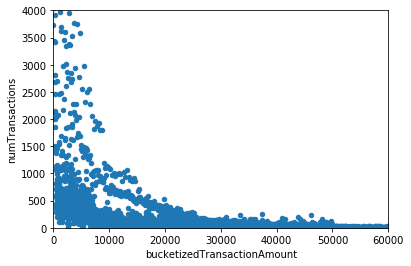

In [9]:
transactions.plot(kind="scatter", 
                  x="bucketizedTransactionAmount", y="numTransactions",
                  ylim=(0, 4000), xlim=(0, 60000))

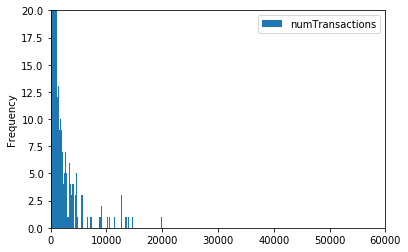

In [10]:
transactions.plot(kind="hist", bins=1000,
                  x="bucketizedTransactionAmount", y="numTransactions",
                  ylim=(0, 20), xlim=(0, 60000))

# Now it's up to you